<a href="https://colab.research.google.com/github/enino84/Data_Visualization/blob/main/Data_Visualization_Barranquilla_Accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Análisis Accidentes de Tránsito Barranquilla

In [ ]:
#LIBRERIAS NECESARIAS
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium import plugins
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
import scipy.integrate as integrate
import scipy.special as special
import scipy.integrate as sciint

#`Read and fit dataset`












In [ ]:
df_acc = pd.read_csv('https://www.datos.gov.co/api/views/yb9r-2dsi/rows.csv?accessType=DOWNLOAD');

In [ ]:
df_acc.head(5)

,FECHA_ACCIDENTE,AÑO_ACCIDENTE,MES_ACCIDENTE,DIA_ACCIDENTE,HORA_ACCIDENTE,GRAVEDAD_ACCIDENTE,CLASE_ACCIDENTE,SITIO_EXACTO_ACCIDENTE,CANT_HERIDOS_EN _SITIO_ACCIDENTE,CANT_MUERTOS_EN _SITIO_ACCIDENTE,CANTIDAD_ACCIDENTES
0,01/01/2015 12:00:00 AM,2015,1,Jue,02:10:00:PM,Con heridos,Choque,VIA 40 CON 77,1.0,NaN,1
1,01/01/2015 12:00:00 AM,2015,1,Jue,02:15:00:PM,Solo daños,Choque,CALLE 14 CR 13,NaN,NaN,1
2,01/01/2015 12:00:00 AM,2015,1,Jue,02:20:00:PM,Solo daños,Choque,CL 74 CR 38C,NaN,NaN,1
3,01/01/2015 12:00:00 AM,2015,1,Jue,03:30:00:PM,Con heridos,Choque,CL 45 CR 19,2.0,NaN,1
4,01/01/2015 12:00:00 AM,2015,1,Jue,04:20:00:AM,Solo daños,Choque,CRA 15 CLLE 21,NaN,NaN,1


In [ ]:
df_acc['FECHA_ACCIDENTE'] = pd.to_datetime(df_acc['FECHA_ACCIDENTE']);

In [ ]:
df_acc['HORA_ACCIDENTE'] = pd.to_datetime(df_acc['HORA_ACCIDENTE'], format='%I:%M:%S:%p');

In [ ]:
fecha = df_acc['FECHA_ACCIDENTE'];
hora = df_acc['HORA_ACCIDENTE'];
df_acc['fecha'] = fecha + pd.to_timedelta(hora.dt.hour, unit='hr') + pd.to_timedelta(hora.dt.minute, unit='min') 

In [ ]:
df_acc.drop(columns=['FECHA_ACCIDENTE','HORA_ACCIDENTE','AÑO_ACCIDENTE','MES_ACCIDENTE','DIA_ACCIDENTE'], inplace=True)

In [ ]:
df_acc.columns = ['gravedad','clase','sitio','heridos','muertes','accidentes','fecha'];

#`cleaning dataset`



In [ ]:
# replace nan values with 0
df_acc=df_acc.replace(to_replace = np.nan, value =0)
df_acc['sitio'].replace(to_replace=np.nan, value='NO REPORTA');

In [ ]:
#change data type of heridos and muertes columns
df_acc['heridos']=df_acc['heridos'].astype('int32');
df_acc['muertes']=df_acc['muertes'].astype('int32');

In [ ]:
df_acc.head(5)

,gravedad,clase,sitio,heridos,muertes,accidentes,fecha
0,Con heridos,Choque,VIA 40 CON 77,1,0,1,2015-01-01 14:10:00
1,Solo daños,Choque,CALLE 14 CR 13,0,0,1,2015-01-01 14:15:00
2,Solo daños,Choque,CL 74 CR 38C,0,0,1,2015-01-01 14:20:00
3,Con heridos,Choque,CL 45 CR 19,2,0,1,2015-01-01 15:30:00
4,Solo daños,Choque,CRA 15 CLLE 21,0,0,1,2015-01-01 04:20:00


In [ ]:
#upper address
df_acc['sitio']=df_acc['sitio'].str.upper()

In [ ]:
#split each address in parts 
table_address=df_acc['sitio'].str.split('([0-9]+| )|\.', expand=True)

In [ ]:
# Standard Addresses
def replace_address(TEMPORAL):  
  #general "CALLE"
  CALLES=["CL","CCLLE","CLL","CLLE","CALE","CLEL","CLLA","CZALLE","CALL","ALLE","CC","C.C","CALLEC","LL","CLE","CELL","CA","CLK","CALLES","CALLR","CALLW","C,LLE"]
  TEMPORAL=TEMPORAL.replace(to_replace=CALLES, value="CALLE")
    
  #GENERAL "CARRERA"
  CARRERAS=["CRA","CR","CRE","CREA","CRR","CRARRERA","KRA","CRC","CARRERS","CARRERAN","CARRERAB","CRT","KR","K","CARREA","CARRERAS","CAR"]
  TEMPORAL=TEMPORAL.replace(to_replace=CARRERAS, value="CARRERA")

  #GENERAL "AVENIDA"
  AVENIDAS=["AV","AVENIAD","AVENIDAD","AVB","AVENUDA","VENIDA","AVE","AVENIUDA","AVNIDA"]
  TEMPORAL=TEMPORAL.replace(to_replace=AVENIDAS, value="AVENIDA")

  #CIRCUNVALAR 
  CIRCUNVALARES=["CIRUNVALAR","CIRCUNV","CIRCUNVLAR","CIRCNVALAR","CIRCUNAVALR","CIRC","CIRCUNAVALAR","CIRCVUNVALAR","CIRCULAR","CIRCUANVALAR","CIRCUUNVALAR","CIRCUNVALR","CIRCUNV","CIRUNVALAR","CIRCNV","CIRCUVALAR","CIRVCUNVALAR","ICRCUNVALAR","CICRUNVALAR","CIRCUVALAR","CIRCUNV","CIRCUNVALARY","CIRCUNAVALAR","CIRCUNV","CIRUNVALAR","CIRCUNV","CIRUNVALAR"]
  TEMPORAL=TEMPORAL.replace(to_replace=CIRCUNVALARES, value="CIRCUNVALAR")
  
  #

  #TODO: CORDIALIDAD,TRANSVERSAL,CORREDOR, #,

  #CORDIALIDAD
  CORDIALIDAD=["CORDIAIDAD","CORDIALIDA","CORD","CORDIALIADD","CORIDALIDAD","CORDIALIAD","CORDIALIDA","VILLACORDIALIDAD"]
  TEMPORAL=TEMPORAL.replace(to_replace=CORDIALIDAD, value="CORDIALIDAD")

  #TRANSVERSAL
  TRANSVERSAL=["TRANSVERSSAL","TRANSV","TRANS"]
  TEMPORAL=TEMPORAL.replace(to_replace=TRANSVERSAL, value="TRANSVERSAL")
  #KM
  KM=["KMS"]
  TEMPORAL=TEMPORAL.replace(to_replace=KM, value="KM")

  #NUMERAL
  NUMERAL=["NUMERO","NUM","NO","N°"]
  TEMPORAL=TEMPORAL.replace(to_replace=NUMERAL, value="#")
  return TEMPORAL

In [ ]:
#STANDARD adresses
for i in table_address:
  table_address[i]=replace_address(table_address[i])

In [ ]:
#identify ways to standar addresses
for i in table_address:
  print(i)
  print(table_address[i].unique())
  print(" ")

0
['VIA' 'CALLE' 'CARRERA' 'AVENIDA' 'CONCENTRADOS' 'ESTACION' 'DIAG'
 'PUENTE' 'KM' 'CIRCUNVALAR' 'GLORIETA' 'TRANSVERSAL' 'CORDIALIDAD' 'AC'
 'FRENTE' 'PEAJE' 'SALIDA' 'ROMBOY' 'PARQUEADERO' 'C' 'MURILLO' 'ARGOS'
 'SOCIEDAD' 'CENTRO' 'PROLONGACION' 'COORDIALIDAD' 'A' 'EXTENCION' 'LAS'
 'RETORNO' 'KILOMETRO' 'SUBIDA' 'TROCHA' 'TRANVERSAL' nan 'ENTRADA'
 'CEMENTOS' 'DIAGONAL' 'DG' 'CRV' 'PASO' 'METROPARQUE' 'EXITO'
 'BARRANQUILLA' 'ZONA' 'PARTE' 'OREJA' 'SOTANO' 'GALAPA' '' 'EDS'
 'TRONCAL' 'PARQUEDAERO' 'CORREDOR' 'ENTRE' 'CIA' 'INTERIR' 'PUERTO'
 'PARALELA' 'NUEVO' 'PATIO' 'DR' 'MONOMEROS' 'TRASNVERSAL' 'PARQUE']
 
1
[' ' '38' '50' '30' '86' nan '80' '47' '46' '68' '110' None '72' '15' '6'
 '43' '76' '5' '69' '90']
 
2
['' 'CIRCUNVALAR' 'C' 'DEL' 'DE' 'JUAN' 'CORDIALIDAD' 'GALAPA' 'PUMAREJO'
 'CARRERA' 'HAMBURGO' 'CALLE' 'FRENTE' 'CON' 'BQUILLA' 'VIA' 'ENTRE' 'A'
 'MUIRILLO' 'COORDIALIDAD' 'AVENIDA' 'ENTRADA' 'MURILLO' 'SANTAMARTA'
 'LAS' 'EXITO' 'STA' 'RIO' 'EL' 'SANTA' 'PORTUARIA' 

In [ ]:
# join all address part in one columns
table_address["RESULT"]= ' ' 
n_columns=table_address.shape[1]
table_address = table_address.fillna(value='')
for i in range(n_columns-1):
  table_address["RESULT"]=table_address["RESULT"]+table_address[i]

table_address.head()  

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,RESULT
0,VIA,,,40,,,CON,,,77,,,,,,,,,,,,,,,,,,,,,,VIA 40 CON 77
1,CALLE,,,14,,,CARRERA,,,13,,,,,,,,,,,,,,,,,,,,,,CALLE 14 CARRERA 13
2,CALLE,,,74,,,CARRERA,,,38,C,,,,,,,,,,,,,,,,,,,,,CALLE 74 CARRERA 38C
3,CALLE,,,45,,,CARRERA,,,19,,,,,,,,,,,,,,,,,,,,,,CALLE 45 CARRERA 19
4,CARRERA,,,15,,,CALLE,,,21,,,,,,,,,,,,,,,,,,,,,,CARRERA 15 CALLE 21


In [ ]:
df_acc['sitio']=table_address["RESULT"]
df_acc.head()

,gravedad,clase,sitio,heridos,muertes,accidentes,fecha
0,Con heridos,Choque,VIA 40 CON 77,1,0,1,2015-01-01 14:10:00
1,Solo daños,Choque,CALLE 14 CARRERA 13,0,0,1,2015-01-01 14:15:00
2,Solo daños,Choque,CALLE 74 CARRERA 38C,0,0,1,2015-01-01 14:20:00
3,Con heridos,Choque,CALLE 45 CARRERA 19,2,0,1,2015-01-01 15:30:00
4,Solo daños,Choque,CARRERA 15 CALLE 21,0,0,1,2015-01-01 04:20:00


In [ ]:
#REMPLAZAR AVENIDA CIRVUNVALAR

def replace_cir(TEMPORAL):
  TEMPORAL=TEMPORAL.replace("AVENIDA CIRCUNVALAR", "CALLE 110")
  TEMPORAL=TEMPORAL.replace("CIRCUNVALAR", "CALLE 110")
  return TEMPORAL


In [ ]:
for i in range(len(df_acc)):  
  df_acc['sitio'][i]=replace_cir(df_acc['sitio'][i])  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#trim addresses
df_acc['sitio'] = df_acc['sitio'].str.lstrip();
df_acc['sitio'] = df_acc['sitio'].str.rstrip();

In [ ]:
df_acc.head(5)

,gravedad,clase,sitio,heridos,muertes,accidentes,fecha
0,Con heridos,Choque,VIA 40 CON 77,1,0,1,2015-01-01 14:10:00
1,Solo daños,Choque,CALLE 14 CARRERA 13,0,0,1,2015-01-01 14:15:00
2,Solo daños,Choque,CALLE 74 CARRERA 38C,0,0,1,2015-01-01 14:20:00
3,Con heridos,Choque,CALLE 45 CARRERA 19,2,0,1,2015-01-01 15:30:00
4,Solo daños,Choque,CARRERA 15 CALLE 21,0,0,1,2015-01-01 04:20:00


In [ ]:
#save dataset in .csv file
#df_acc.to_csv('/content/drive/MyDrive/PF/DF_ACC.csv')

## Sitios top de Barranquilla segun la cantidad de accidente

In [ ]:
newDF = pd.DataFrame()
newDF['sitio']=df_acc['sitio']
newDF['cant_acc']=df_acc['accidentes']
newDF.head()

,sitio,cant_acc
0,VIA 40 CON 77,1
1,CALLE 14 CARRERA 13,1
2,CALLE 74 CARRERA 38C,1
3,CALLE 45 CARRERA 19,1
4,CARRERA 15 CALLE 21,1


In [ ]:
#count amount of accidents by address
newDF=newDF.groupby(['sitio']).sum().nlargest(50, 'cant_acc').reset_index()
newDF['sitio_to_plot']=newDF['sitio']
newDF['sitio_to_plot']=newDF['sitio_to_plot'].replace(to_replace = 'VIA 40', value ='CRA 82')
newDF.head(5)


,sitio,cant_acc,sitio_to_plot
0,CALLE 110 CARRERA 9G,401,CALLE 110 CARRERA 9G
1,CALLE 110 CARRERA 6,315,CALLE 110 CARRERA 6
2,CALLE 17 CARRERA 8,310,CALLE 17 CARRERA 8
3,CALLE 30 CARRERA 8,284,CALLE 30 CARRERA 8
4,CALLE 110 CARRERA 38,274,CALLE 110 CARRERA 38


## Geocoding addresses


In [ ]:
#fit the address to geocode it
table_address2=newDF['sitio_to_plot'].str.split(' ', expand=True)
table_address2[:][2]= '#'  #table_address2[:][2] #

table_address2["RESULT"]= ' '
n_columns=table_address2.shape[1]

for i in range(n_columns-1):
  table_address2["RESULT"]=table_address2["RESULT"]+' '+table_address2[i]
table_address2

newDF['sitio_to_plot']=table_address2['RESULT']
newDF.tail(5)

,sitio,cant_acc,sitio_to_plot
45,VIA 40 CALLE 75,79,VIA 40 # 75
46,CALLE 110 CALLE 51B,78,CALLE 110 # 51B
47,CALLE 19 CARRERA 1E,78,CALLE 19 # 1E
48,CARRERA 51B CALLE 98,76,CARRERA 51B # 98
49,CALLE 6 CARRERA 30,74,CALLE 6 # 30


In [ ]:
#geocoding addresses
geolocator = Nominatim(user_agent="final_project") #Google Maps
newDF['latitud']=np.nan
newDF['longitud']=np.nan

for i in range(newDF.shape[0]):
  #print(str(newDF['sitio_to_plot'][i]) + ', Barranquilla')
  location = geolocator.geocode(str(newDF['sitio_to_plot'][i]) + ', Barranquilla',timeout=10)
  newDF['latitud'][i]=location.latitude
  newDF['longitud'][i]=location.longitude

newDF.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,sitio,cant_acc,sitio_to_plot,latitud,longitud
0,CALLE 110 CARRERA 9G,401,CALLE 110 # 9G,10.950915,-74.834270
1,CALLE 110 CARRERA 6,315,CALLE 110 # 6,10.950915,-74.834270
2,CALLE 17 CARRERA 8,310,CALLE 17 # 8,10.956031,-74.774138
3,CALLE 30 CARRERA 8,284,CALLE 30 # 8,10.989577,-74.778251
4,CALLE 110 CARRERA 38,274,CALLE 110 # 38,10.950915,-74.834270


In [ ]:
#save dataset in .csv file
#newDF.to_csv('/content/drive/MyDrive/PF/NEWDF.csv')

## Descriptivo - Folium + Heatmap

In [ ]:
#Creating the map
map = folium.Map(location=[newDF["latitud"].mean(), newDF["longitud"].mean()], zoom_start=14, control_scale=True)

In [ ]:
#Heat map
heat_data = [[row['latitud'],row['longitud']] for index, row in newDF.iterrows()]
HeatMap(heat_data).add_to(folium.FeatureGroup(name='Heat Map').add_to(map))
folium.LayerControl().add_to(map)

In [ ]:
map

#`KDE model`

In [ ]:
#get info of each top address
data_merged= newDF.merge(df_acc, how="inner", on="sitio")

data_merged=data_merged.drop(columns=["cant_acc"])
data_merged["hora"] = data_merged['fecha'].dt.hour
data_merged.head(5)

,sitio,sitio_to_plot,latitud,longitud,gravedad,clase,heridos,muertes,accidentes,fecha,hora
0,CALLE 110 CARRERA 9G,CALLE 110 # 9G,10.950915,-74.83427,Solo daños,Choque,0,0,1,2015-01-04 03:24:00,3
1,CALLE 110 CARRERA 9G,CALLE 110 # 9G,10.950915,-74.83427,Solo daños,Choque,0,0,1,2015-01-31 20:40:00,20
2,CALLE 110 CARRERA 9G,CALLE 110 # 9G,10.950915,-74.83427,Solo daños,Choque,0,0,1,2015-03-20 12:30:00,12
3,CALLE 110 CARRERA 9G,CALLE 110 # 9G,10.950915,-74.83427,Solo daños,Choque,0,0,1,2015-05-04 07:20:00,7
4,CALLE 110 CARRERA 9G,CALLE 110 # 9G,10.950915,-74.83427,Solo daños,Choque,0,0,1,2015-09-05 07:30:00,7


In [ ]:
#save dataset in .csv file
#data_merged.to_csv('/content/drive/MyDrive/PF/DATA_MERGED.csv')

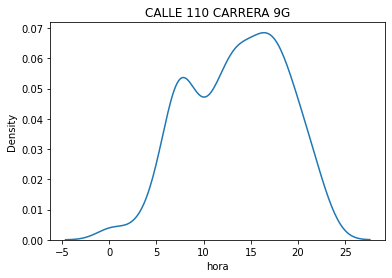

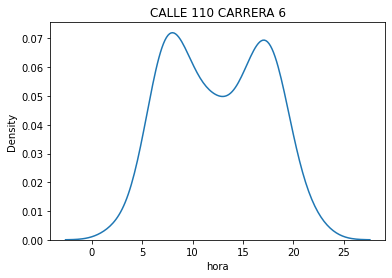

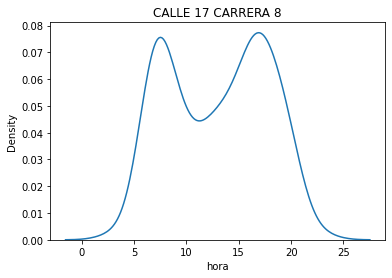

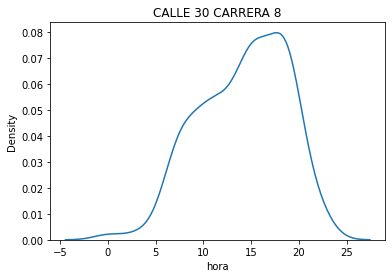

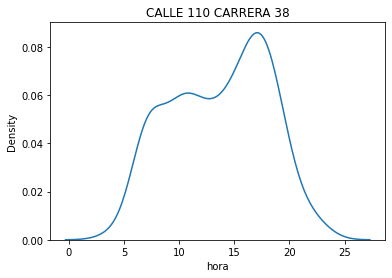

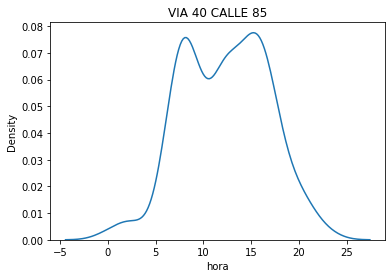

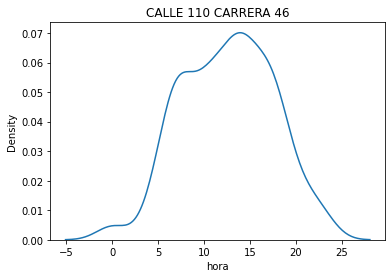

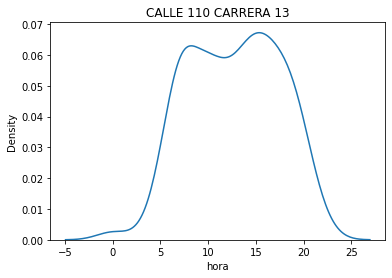

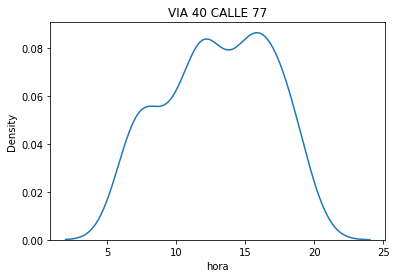

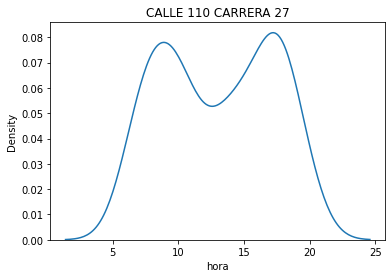

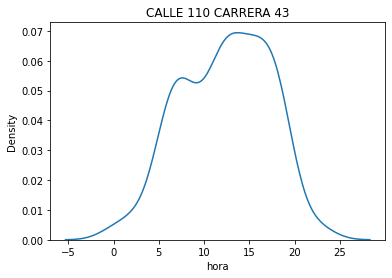

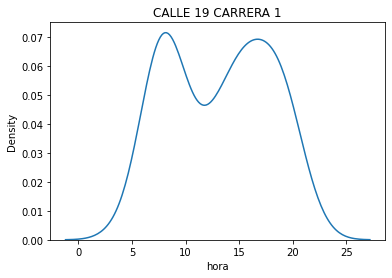

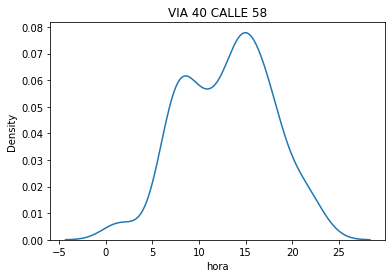

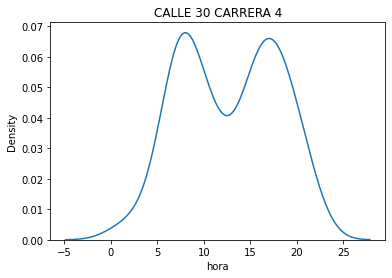

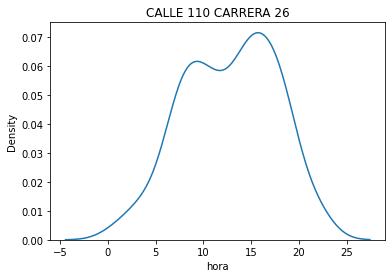

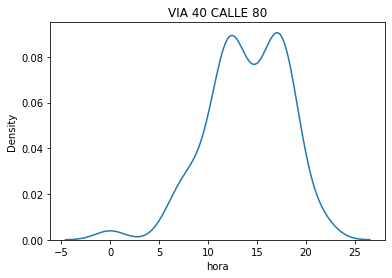

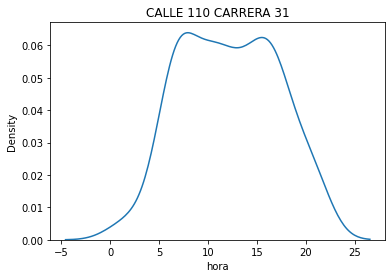

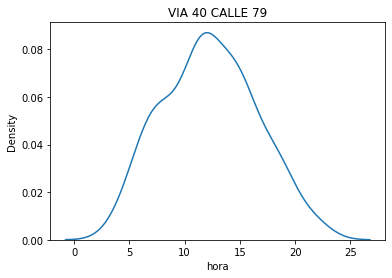

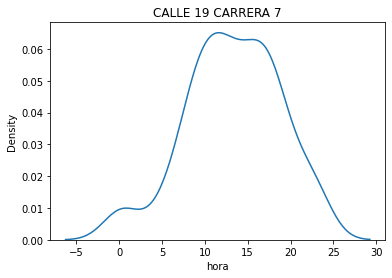

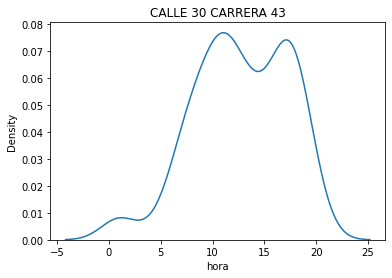

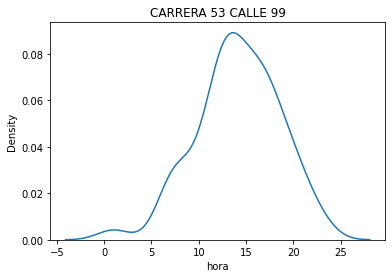

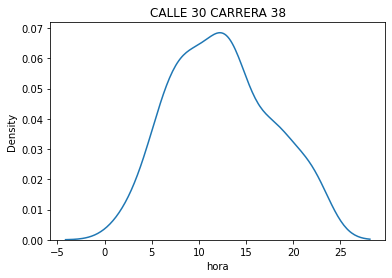

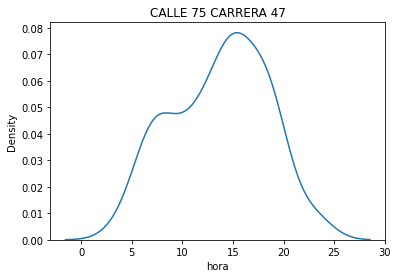

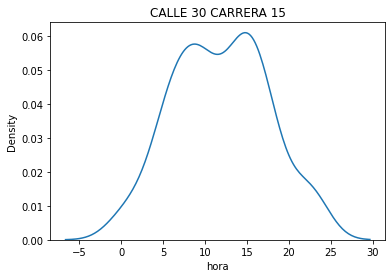

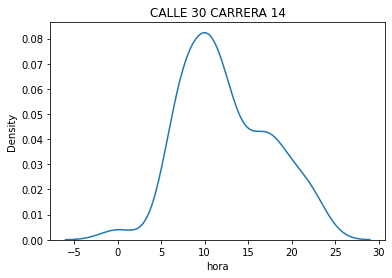

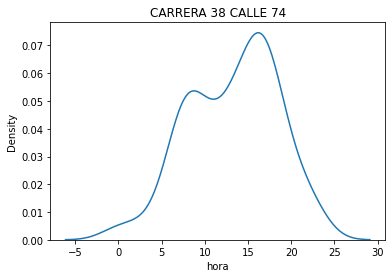

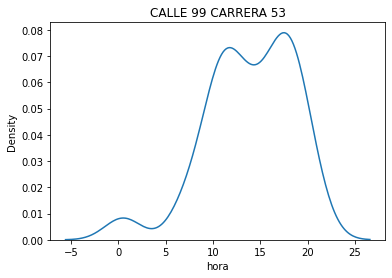

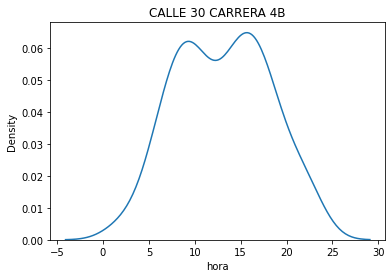

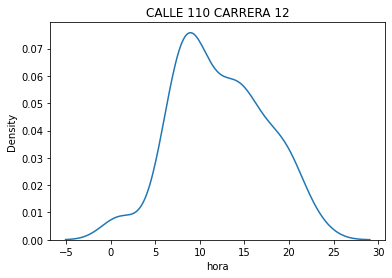

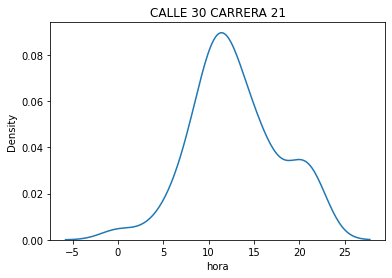

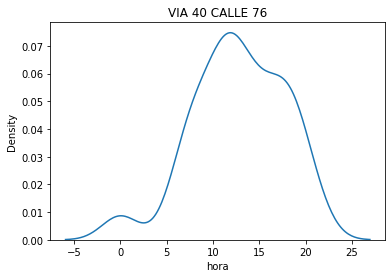

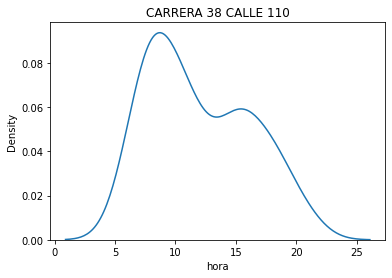

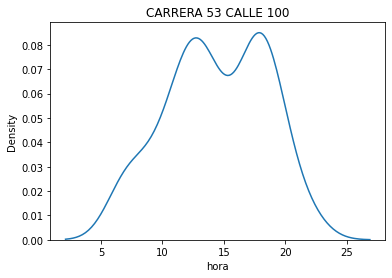

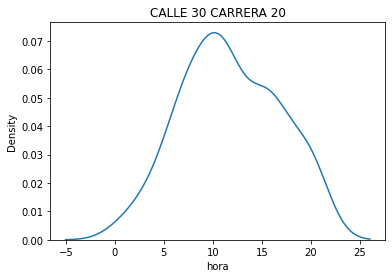

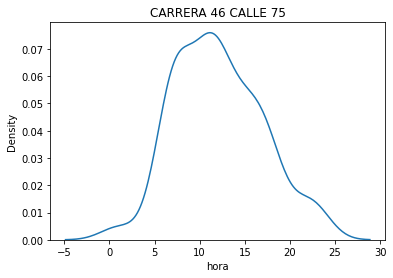

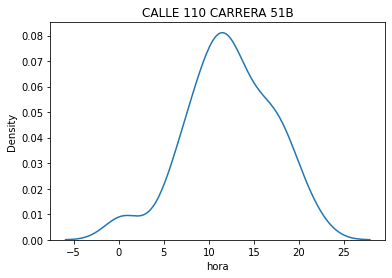

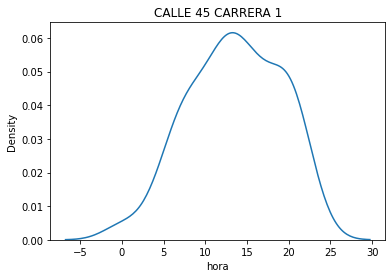

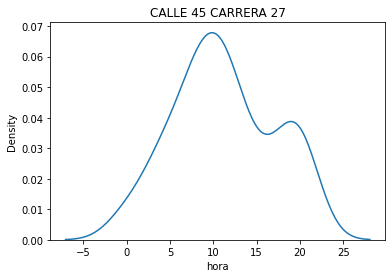

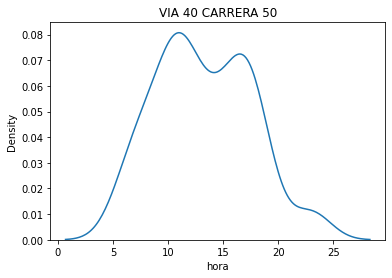

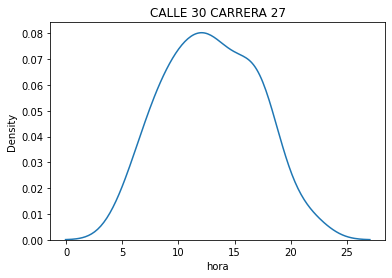

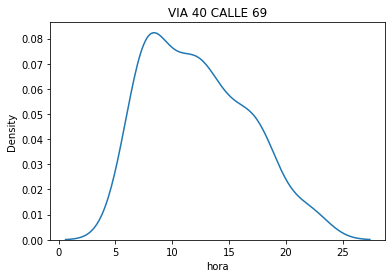

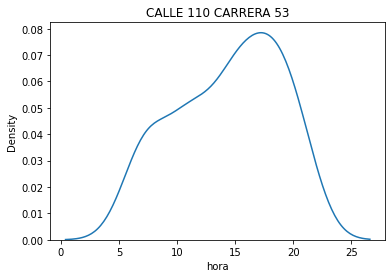

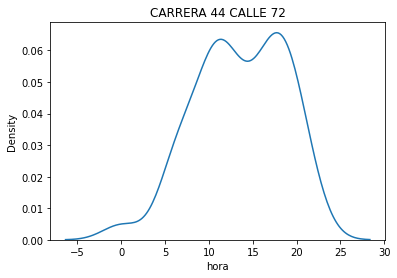

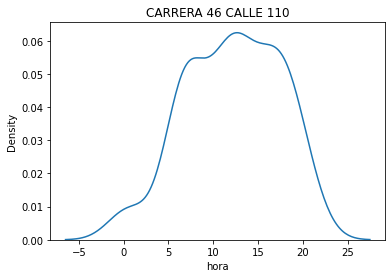

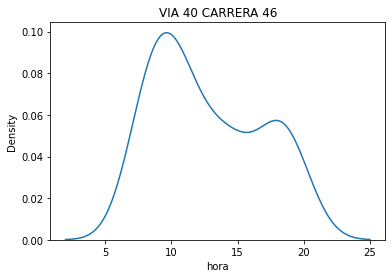

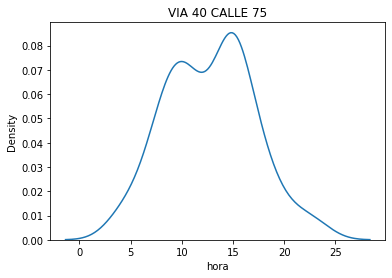

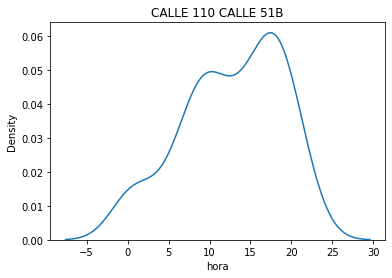

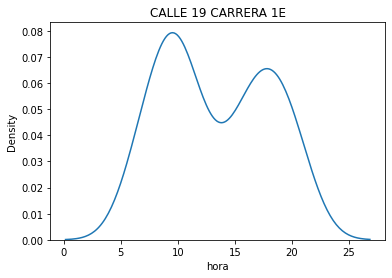

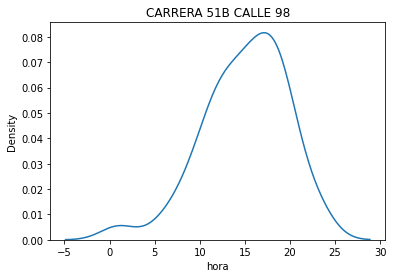

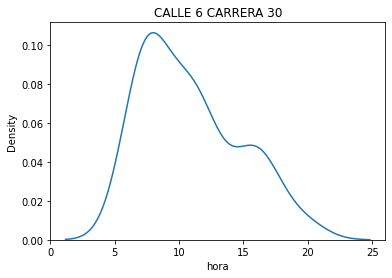

In [ ]:
for sitio in newDF["sitio"]:
  sns.kdeplot(data=data_merged[data_merged["sitio"]==sitio], x="hora")
  #plt.xlabel="Hora Accidente"
  plt.title(sitio, loc='center')
  plt.show()

In [ ]:
kde_data=data_merged[['sitio','hora']]
kde_data.head(5)

,sitio,hora
0,CALLE 110 CARRERA 9G,3
1,CALLE 110 CARRERA 9G,20
2,CALLE 110 CARRERA 9G,12
3,CALLE 110 CARRERA 9G,7
4,CALLE 110 CARRERA 9G,7


In [ ]:
def compute_probability(kde_fit, hora_ini, hora_fin):
  minutos = np.linspace(hora_ini, hora_fin, 60, endpoint=False);
  prob_acc = np.exp(kde_fit.score_samples(minutos.reshape(-1,1)));
  #C = np.sum(prob_acc); #Constant
  #prob_acc = prob_acc/C;
  prob_hora = sciint.simps(prob_acc, minutos);
  return prob_hora;

In [ ]:
df_output = pd.DataFrame(columns=["sitio","INTERVALO","PROBABILIDAD"])
probabilidades=[]
for sitio in newDF["sitio"]:
  kde_data_filtered=kde_data[kde_data.sitio==sitio]
  kde_data_to_fit=kde_data_filtered[['hora']].values;  
  
  #instance and fit the KDE model
  kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
  kde_fit = kde.fit(kde_data_to_fit)
  prob_h = [];
  for hora in range(0, 24):
    hora_ini = hora;
    hora_fin = hora+1;
    proba = compute_probability(kde_fit, hora_ini, hora_fin)
    row={
          "sitio":sitio,
          "INTERVALO" : f"{hora_ini}-{hora_fin}",
          "PROBABILIDAD": proba
        }
    prob_h.append(proba)
    df_output=df_output.append(row, ignore_index=True);
  probabilidades.append(prob_h)
df_output.head(5)  

,sitio,INTERVALO,PROBABILIDAD
0,CALLE 110 CARRERA 9G,0-1,0.007056
1,CALLE 110 CARRERA 9G,1-2,0.002702
2,CALLE 110 CARRERA 9G,2-3,0.002637
3,CALLE 110 CARRERA 9G,3-4,0.007314
4,CALLE 110 CARRERA 9G,4-5,0.012532


In [ ]:
#print(df_output.shape())
df_output = df_output.merge(newDF, how="inner", on="sitio")
#print(df_output.shape())
df_output=df_output[["sitio","INTERVALO","PROBABILIDAD","latitud","longitud"]]
df_output.head(5)

,sitio,INTERVALO,PROBABILIDAD,latitud,longitud
0,CALLE 110 CARRERA 9G,0-1,0.007056,10.950915,-74.83427
1,CALLE 110 CARRERA 9G,1-2,0.002702,10.950915,-74.83427
2,CALLE 110 CARRERA 9G,2-3,0.002637,10.950915,-74.83427
3,CALLE 110 CARRERA 9G,3-4,0.007314,10.950915,-74.83427
4,CALLE 110 CARRERA 9G,4-5,0.012532,10.950915,-74.83427


In [ ]:
#df_output.to_csv('/content/drive/MyDrive/PF/OUTPUT_MODELO.csv')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
1 in ()